In [ ]:
# 패키지 설치
!pip install yfinance --quiet

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

etf = yf.Tickers(tickers)

data = etf.history(start='2011-01-01', actions=False)

data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)

data = data.droplevel(0, axis=1)

[*********************100%%**********************]  9 of 9 completed


In [3]:
# 수익률
rets = data.pct_change().fillna(0)

# 수익률 벡터
ret_vec = rets.mean() * 252

# 공분산 행렬
cov_mat = rets.cov() * 252


In [4]:
# 효율적 경계선 리샘플링 함수
## size : 시뮬레이션 1년동안
## N_path : 몇번 시뮬레이션 할것인가
## n_point : 효율적 경계선 포인트를 몇개로 쪼갤 것인가
def resampled_efficient_frontier(ret_vec, cov_mat, size=252, N_path=50, N_point=50, resampling=True):

    # 자산 개수
    n = len(ret_vec)

    if resampling:
        # 리샘플링을 위한 시뮬레이션
        ## 빈 배열 만들기
        ret_vec_stack = np.zeros((N_path, len(ret_vec)))
        cov_mat_stack = np.zeros((N_path, len(ret_vec), len(ret_vec)))

        for i in range(N_path):
            # 리샘플링 경로 생성
            # 다변량 정규분포로부터 임의의 난수 추출
            data = np.random.multivariate_normal(ret_vec, cov_mat, size=size)

            # 새롭게 만들어진 기대수익률 벡터
            ret_vec_i = data.mean(axis=0)
            ret_vec_stack[i, :] = ret_vec_i

            # 새롭게 만들어진 공분산 행렬
            cov_mat_i = np.cov(data.T)
            cov_mat_stack[i, :, :] = cov_mat_i

        # 새로 업데이트된 기대수익률 벡터와 공분산 행렬
        new_ret_vec = ret_vec_stack.mean(axis=0)
        new_cov_mat = cov_mat_stack.mean(axis=0)

    else:
        new_ret_vec = ret_vec
        new_cov_mat = cov_mat


    # 목적함수
    def obj_func(weights):

        # 투자 가중치
        weights = np.array(weights)

        # 포트폴리오 변동성
        pvol = np.sqrt(np.dot(weights.T, np.dot(new_cov_mat, weights)))

        return pvol

    # 수익률 수준별 포트폴리오 최적화 수행
    trets = np.linspace(0.1, 0.15, N_point)
    tvols = []

    # 난수를 활용해 임의의 가중치 데이터 생성
    weights = np.random.random(n)
    weights /= np.sum(weights)

    # for문을 돌려 각 목표수익률에 맞는 포트폴리오 변동성 레벨을 계산
    for tret in trets:

        # 투자 가중치 초기값 = 동일가중
        init_guess = np.repeat(1/n, n)

        # 제약조건 (포트폴리오 목표 수익률, 현금 보유 비중 0)
        cons = ({'type': 'eq', 'fun': lambda x: np.array(np.sum(new_ret_vec * x)) - tret},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # 자산별 경계조건 (숏 포지션 불가능)
        bnds = tuple((0.0, 1.0) for x in weights)

        # 최적화 알고리즘 수행
        res = sco.minimize(obj_func,
                           init_guess,
                           method='SLSQP',
                           bounds=bnds,
                           constraints=cons)


        # 최적화 알고리즘을 통해 찾아낸 최적 포트폴리오의 변동성 값을 리스트에 저장
        tvols.append(res['fun'])

    # 포트폴리오 변동성 리스트를 배열로 변환
    tvols = np.array(tvols)

    # 결과값 반환
    return trets, tvols

In [5]:
# 리샘플링 O
new_trets, new_tvols = resampled_efficient_frontier(ret_vec, cov_mat)

# 리샘플링 X
trets, tvols = resampled_efficient_frontier(ret_vec, cov_mat, resampling=False)

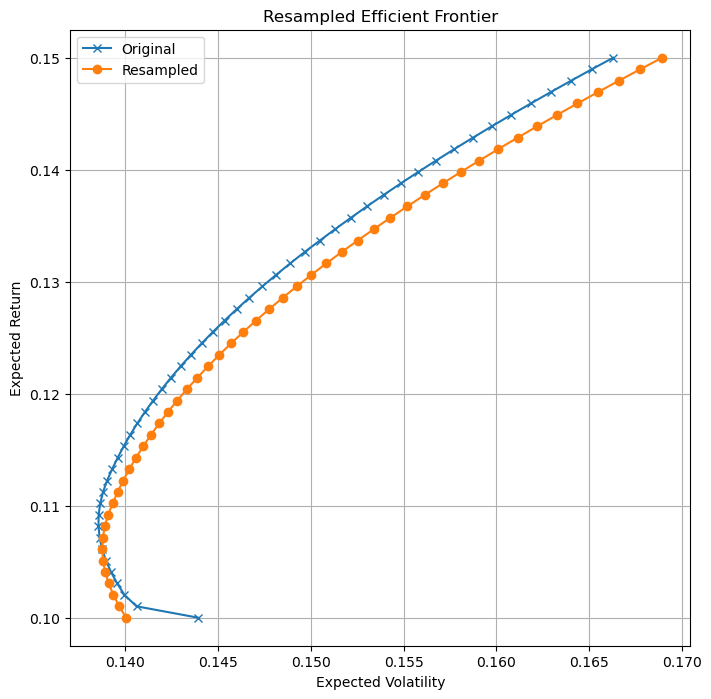

In [6]:
# 리샘플링 효율적 경계선 시각화
plt.figure(figsize=(8, 8))
plt.plot(tvols, trets, marker='x', label='Original')
plt.plot(new_tvols, new_trets, marker='o', label='Resampled')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Resampled Efficient Frontier')
plt.legend()

Copyright 2022. 퀀트대디. All rights reserved.